# Logistic Regression applied to Candidemia data

This notebook is oriented to analyze the Candidemia dataset, prepare the data to fit a logistic regression.

In [1]:
#Import libraries 

import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
#Read the data
data = pd.read_csv('data_candidemia.csv')

#Drop Tempo de Internação
data =  data.drop(['Tempo de Internação', 'Obito Tardio', 'Obito Precoce'], axis=1)

#Dummy coding of categorical covariates
for i in data.drop(['Idade', 'Tempo em UTI', 'TAT-Dias'], axis=1).columns:
    if len(set(data[i].values)) >= 3:
        data =  pd.get_dummies(data=data, columns=[i], dtype=int)

#Rename the columns
new_names = ['Age','Gender','Culture','Recent Abdominal Surgery (within 30 days)','Central Venous Device (CVC, PICC, Hickman, Broviac, Semi-Implantable)',
            'Time in ICU','Fasting Status','Parenteral Nutrition','Dialysis During Candidemia','Mechanical Ventilation','Antibiotic (Vancomycin)',
            'Broad-Spectrum Antibiotic','Prior Use of Azoles','Previous Bacteremia (30 days or at candidemia onset)','Prematurity','Malignancy',
            'Short Bowel','Benign Hematologic Diseases','Inborn Error of Immunity','Neurological Sequelae','Heart Disease', 'Others*',
            'Septic Shock - use of amines', 'Complete Antifungal Treatment in days','Duration of Candidemia <= 2 Days',
            'Duration of Candidemia 3-7 Days', 'Duration of Candidemia >8 Days', 'Duration of Candidemia - Unknown','No SEPSE qSOFA','SEPSE qSOFA',
            'SEPSE qSOFA Unknown','No Disseminated Candidiasis','Disseminated Candidiasis', 'Disseminated Candidiasis Unknown','No Antifungal Treatment',
            'Antifungal Treatment - Azoles','Antifungal Treatment - Amphotericin','Antifungal Treatment - Echinocandidae','Antifungal Treatment - Combination',
            'Catheter Not Removed','Catheter Removed','Catheter Removal Unknown','Catheter Not Removed in the First 3 Days of Candidemia',
            'Catheter Removed in the First 3 Days of Candidemia','Catheter Removed in the First 3 Days of Candidemia - Unknown',
            'Antifungal Response - FAILURE', 'Antifungal Response <72H', 'Antifungal Response 4-7 Days','Antifungal Response >7 Days', 'Antifungal Response - Unknown']
counter = 0
for i in data.columns:
    if i not in ['Neutropenia']:
        data = data.rename({i : new_names[counter]}, axis=1)
        counter = counter + 1
del counter
#Alternative:
#for i,j in enumerate(data.drop(['Neutropenia'], axis=1).columns):
#    data=data.rename({j:new_names[i]}, axis=1)

#Create ICU column to separate patients that have been in ICU with patients that have not
icu = []
for i,j in enumerate(data['Time in ICU'].values):
    if j == 0:
        icu.append(0)
    else:
        icu.append(1)
data['ICU'] = icu

#Check that ICU column was added correctly
data.loc[0:5,['Time in ICU', 'ICU']]

,Time in ICU,ICU
0,51.0,1
1,0.0,0
2,154.0,1
3,0.0,0
4,3.0,1
5,0.0,0


# EDA

In [5]:
#Check the amount of patients that went to UTI
print('ICU Patients: %s  No ICU: %s' % (len(data[data['Time in ICU']==0]), sum(data['Time in ICU'] != 0)))

#Alternative
#data.ICU.value_counts()

ICU Patients: 36  No ICU: 62


According with the dataset, we can see that 36 patients were taken to ICU.

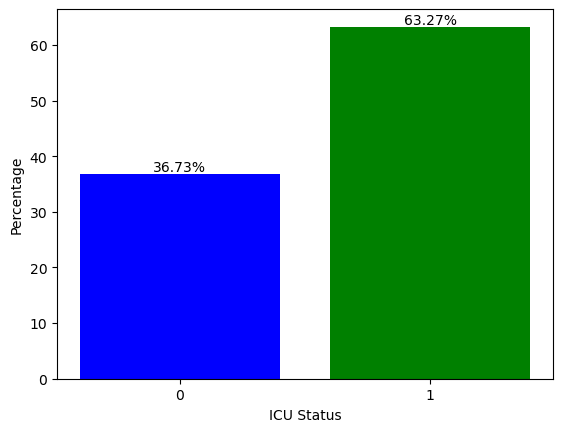

In [166]:
#Bar plot of the patients that were admitted to ICU against the patients who were not

percentage_0 = round((sum(data.ICU == 0)/len(data))*100, 2)
#Alternative: (data.ICU == 0).mean() * 100
percentage_1 = round((sum(data.ICU == 1)/len(data))*100, 2)

#Bar object to set the bars
bar = plt.bar(x= list(set(data.ICU.values)), height=[percentage_0, percentage_1], color= ['blue','green'])
#Change x axis 
plt.xticks(list(set(data.ICU.values)))
#Add percentage at the top of the bars
plt.bar_label(container= bar, labels=[str(percentage_0)+'%', str(percentage_1)+'%'], label_type= 'edge')
#Y label
plt.ylabel('Percentage')
#X label
plt.xlabel('ICU Status')
plt.show()

36.73% of the patients were admitted to the ICU.

In [24]:
#Features average grouped by ICU status
round(data[['Age','Complete Antifungal Treatment in days','Time in ICU','ICU']].groupby('ICU').mean(),4)

,Age,Complete Antifungal Treatment in days,Time in ICU
ICU,,,
0,64.4722,22.1667,0.0000
1,24.5806,18.8065,32.5484


In [108]:
#Function used to convert Age in months to years
def month(month):
    year = round(month//12)
    months = round(month % 12)
    return year, months

#Convert months to years and months
year_0, month_0 = month(64.4722)
year_1, month_1 = month(24.5806)

#Library used to print a markdown 
from IPython.display import Markdown as Md
Md(f"As stated in the table, we can see that the average age for patients admitted to the ICU is {year_1} years and {month_1} months. While for patients that did not required ICU is {year_0} years and {month_0} months, suggesting a tendency for younger patients to be more likely to require intensive care.")

As stated in the table, we can see that the average age for patients admitted to the ICU is 2 years and 1 months. While for patients that did not required ICU is 5 years and 4 months, suggesting a tendency for younger patients to be more likely to require intensive care.

It's worthy to highlight that patients admitted to the ICU, in average received an antifungal treatment of approximately 19 days, while people that did not required an intensive care had an average treatment of 22 days. Also, we can notice that people admitted to the ICU had an average stay of 32 days approximately.

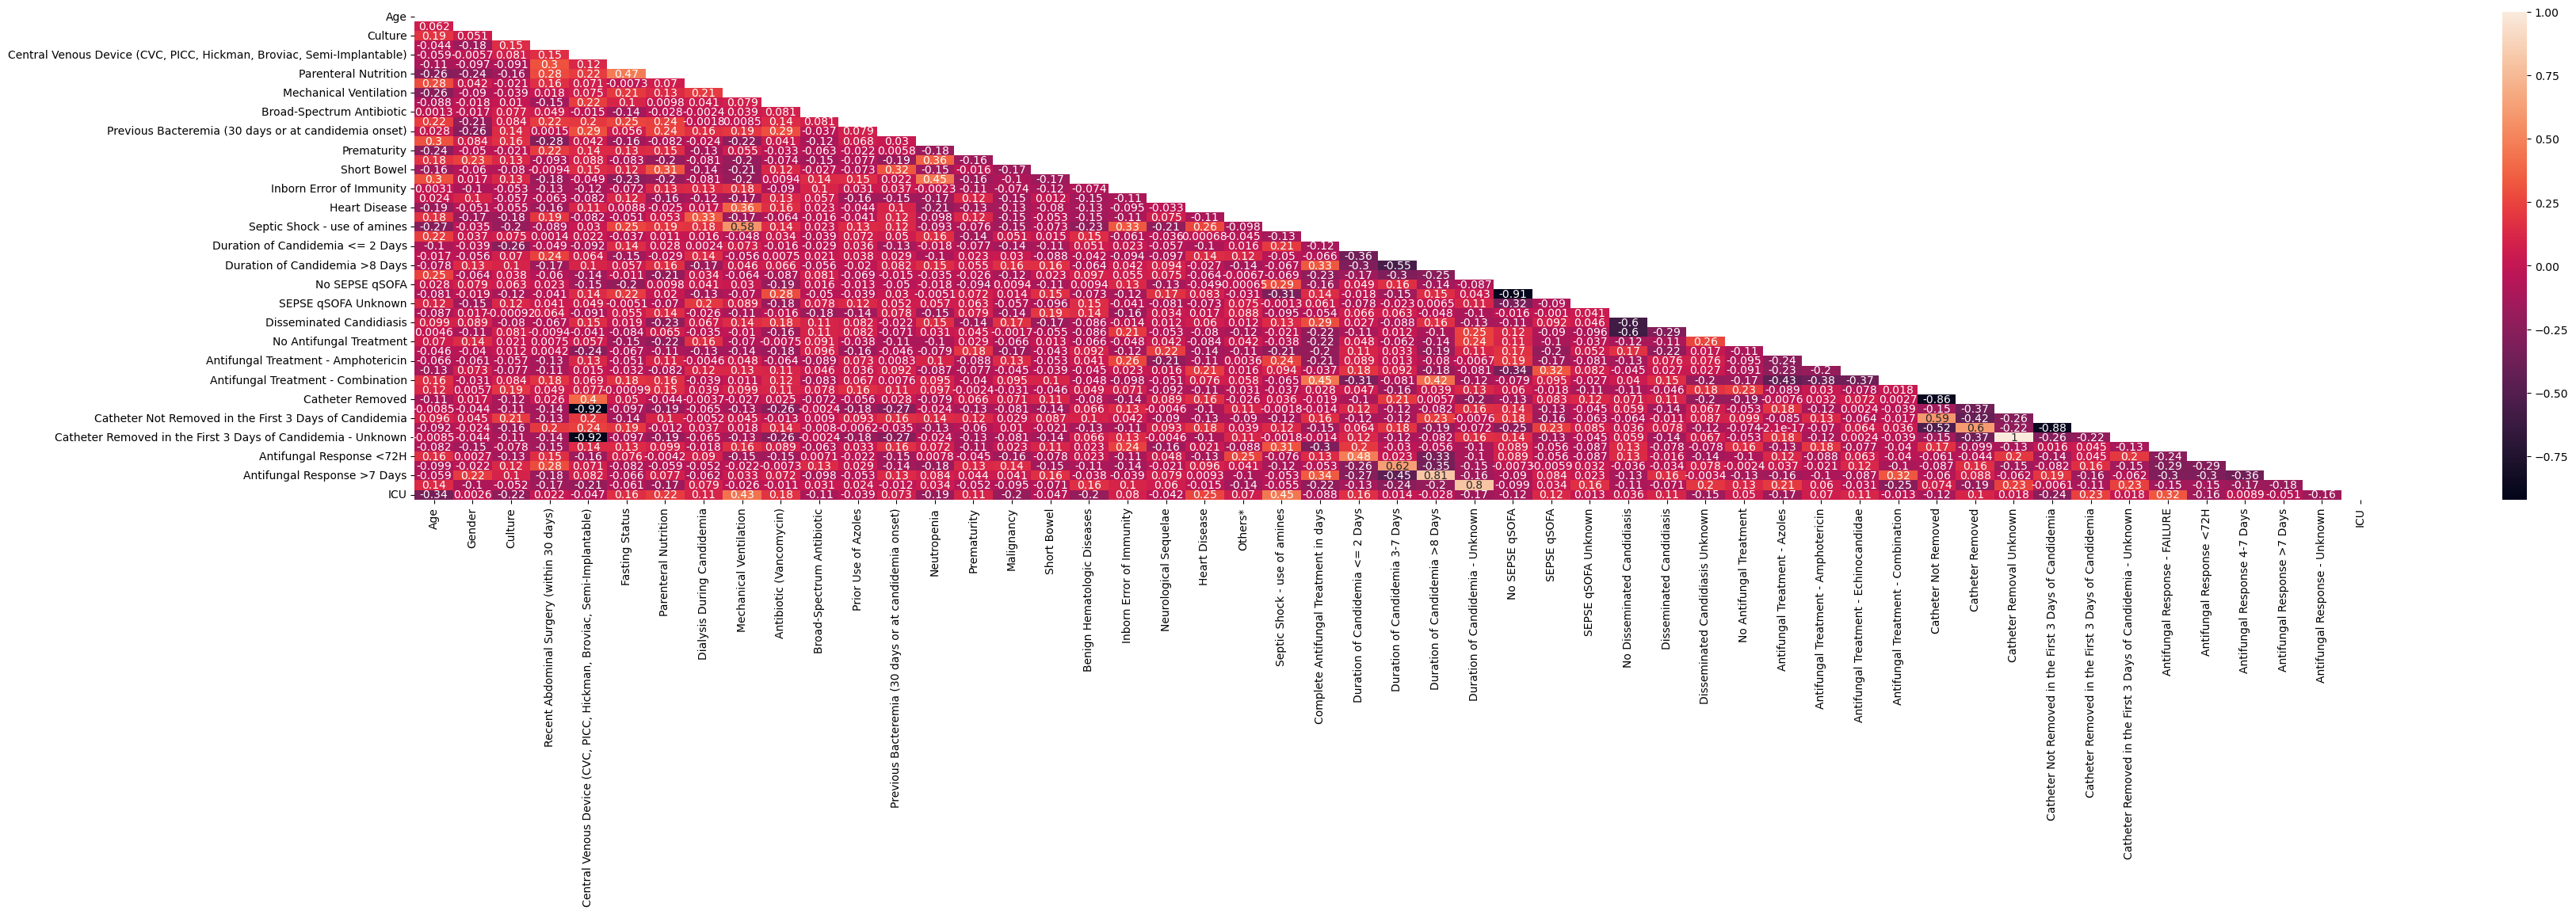

In [211]:
#Heatmap
plt.figure(figsize=(40,8))
correlation = data.drop(['Time in ICU'], axis=1).corr()
mask = np.tri(*correlation.shape).T
#What this mask does is that creates a triangular matrix assuming the shape of the correlation variable, a triangular matrix has one area under the main diagonal
#Full of zeros and the other one full of ones, what we do with the T is apply the transposed function to set the zeros under the main diagonal
sns.heatmap(correlation,mask=mask, annot=True)
plt.show()

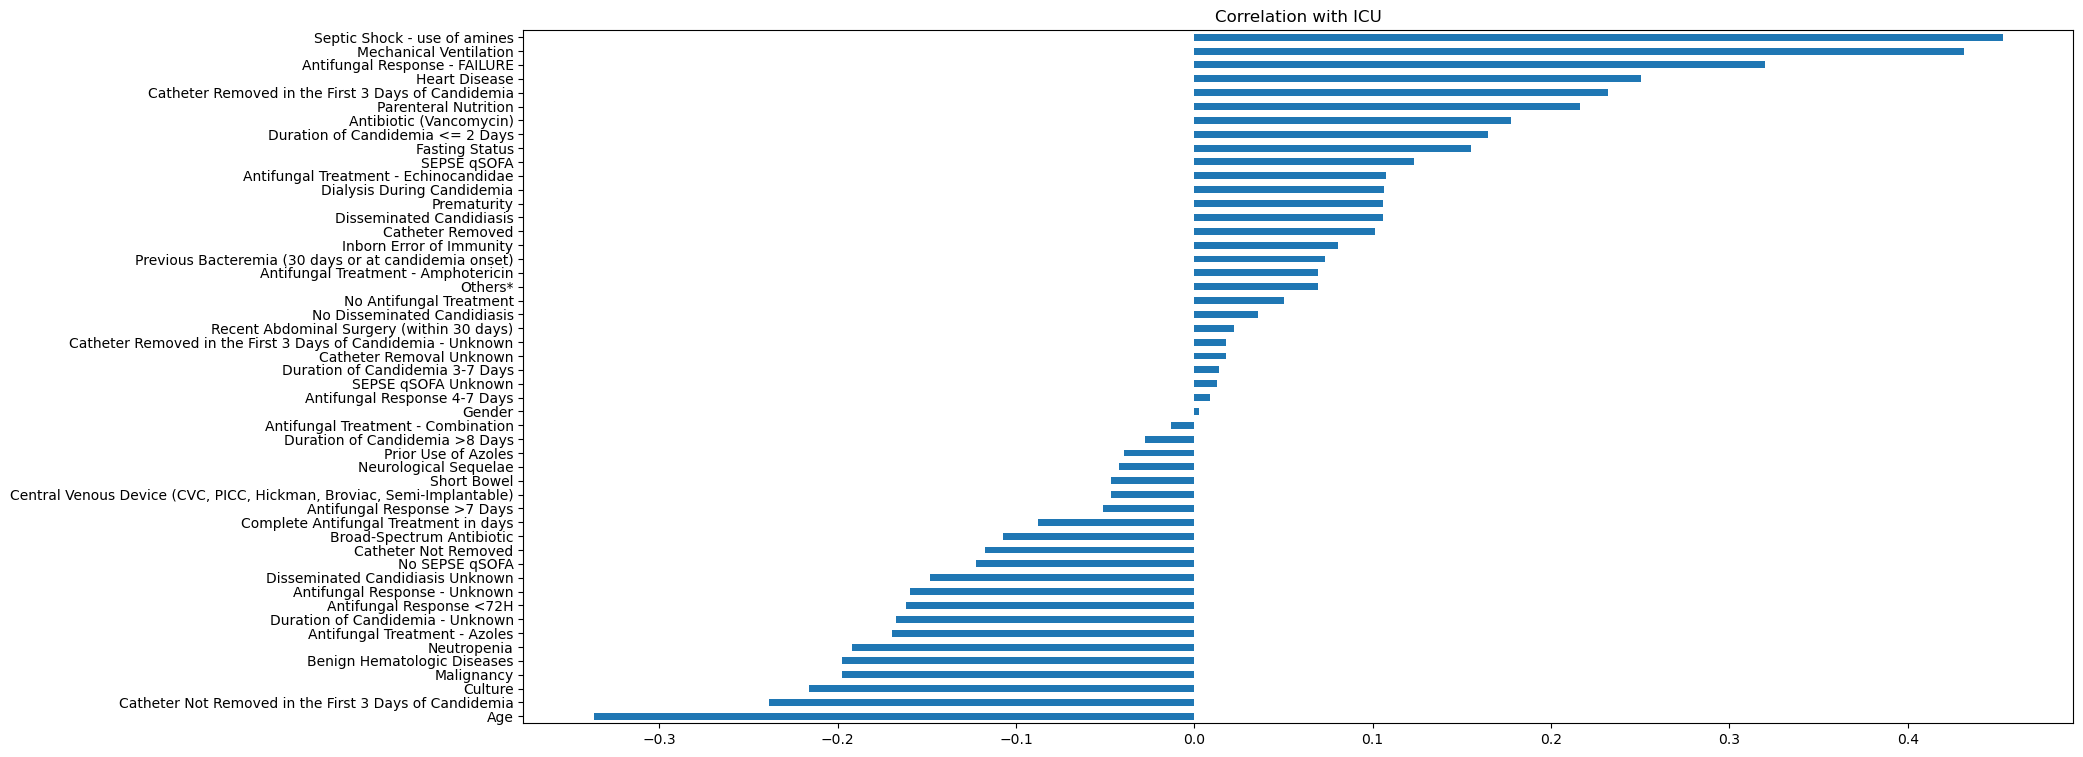

Age                                                                     -0.336700
Catheter Not Removed in the First 3 Days of Candidemia                  -0.238499
Culture                                                                 -0.215772
Malignancy                                                              -0.197442
Benign Hematologic Diseases                                             -0.197442
Neutropenia                                                             -0.191855
Antifungal Treatment - Azoles                                           -0.169494
Duration of Candidemia - Unknown                                        -0.167358
Antifungal Response <72H                                                -0.161716
Antifungal Response - Unknown                                           -0.159345
Disseminated Candidiasis Unknown                                        -0.148047
No SEPSE qSOFA                                                          -0.122312
Catheter Not Rem

In [5]:
#Correlation with ICU
data.drop(['Time in ICU','ICU'], axis=1).corrwith(data.ICU).sort_values(ascending=True).plot(kind='barh', figsize=(20,9))
plt.title('Correlation with ICU')
plt.show()

#Print the R2 coefficients
data.drop(['Time in ICU','ICU'], axis=1).corrwith(data.ICU).sort_values(ascending=True)

### Interpretation of some relevant outcomes

- **Age = -0.336700** </br>
This outcome indicates a moderate negative association between ICU status and Age. This negative value can be interpreted as:</br>
*Younger patients are more likely to be admitted to the ICU.* </br>
*Older patients are less likely to require ICU care, according with the dataset.* </br>
**Direction of the Correlation:** A **negative coefficient** indicates as Age increases, the probability of ICU admission decreases.</br>
**Strength:** A correlation around -0.3367 is moderately strong in clinical datasets and suggest a meaningful relationship.</br>

- **Catheter Not Removed in the First 3 Days of Candidemia = -0.238499**</br>
As stated in the table, the outcome shows a weak-to-moderate relationship between ICU status and Catheter Not Removed in the First 3 Days of Candidemia. A negative correlation can be interpreted as:</br>
*Patients whose catheters were not removed early are less likely to be in the ICU.* </br>
*Patients whose catheters were removed within 3 days tend to be more likely to be in the ICU.* </br>
**Direction:** Because catheter not removed = 1 and ICU = 1, a negative correlation indicates that these two events occur less frequently together. In other words, ICU patients tend to have their catherters removed earlier. </br>
**Strength:** Correlation around -0.24 is modest, not very strong but still meaningful and not random.</br>

- **Mechanical Ventilation = 0.431718** </br>
The outcome suggest a moderate positive relationship between ICU status and Mechanical Ventilation, meaning that:</br>
*Patients that received mechanical ventilation are associates with being admitted to the ICU.* </br>
*Patients that did not received mechanical ventilation are less likely to require intensive care.* </br>
**Direction:** A positive value means that when a patient received ventilation (Mechanical Ventilation = 1), the probability that the ICU status = 1 (the patient was admitted to ICU) increases.</br>
**Strength:** A correlation around 0.43 is not weak but not extremely strong either—it suggests a moderate association between mechanical ventilation and ICU status. </br>

- **Septic Shock - use of amines = 0.453368** </br>
This outcome represents the highiest positive correlated relationship between the outcome variable (ICU status), and a predictor (septic shock). It can be interpreted as follow:</br>
*A positive correlation indicates that patients who required vasoactive amines are more likely to be admitted to the ICU.* </br>
*Conversely, patients who did not need amines were more likely to remain outside the ICU.* </br>
**Direction:** Possitive coefficient, indicating that if a patient required use of amines, it's more likely that patient be admited in the ICU.</br>
**Strength:** A correlation of 0.45 is relatively high in clinical datasets involving mixed variables. It suggests that use of amines is one of the strongest predictors of ICU status in the correlation analysis.

In [5]:
#Extract relevant features

#Correlate it
correlation_ = data.drop(['Time in ICU'],axis=1).corr()
#Correlation target
correlation_target = correlation_.ICU

#Extract relevant features
relevant_features = correlation_target[(correlation_target >= 0.1) | (correlation_target <= -0.1)]
relevant_features.sort_values(ascending=True)

Age                                                      -0.336700
Catheter Not Removed in the First 3 Days of Candidemia   -0.238499
Culture                                                  -0.215772
Benign Hematologic Diseases                              -0.197442
Malignancy                                               -0.197442
Neutropenia                                              -0.191855
Antifungal Treatment - Azoles                            -0.169494
Duration of Candidemia - Unknown                         -0.167358
Antifungal Response <72H                                 -0.161716
Antifungal Response - Unknown                            -0.159345
Disseminated Candidiasis Unknown                         -0.148047
No SEPSE qSOFA                                           -0.122312
Catheter Not Removed                                     -0.117412
Broad-Spectrum Antibiotic                                -0.107524
Catheter Removed                                          0.10

In [7]:
#Example on how to drop a feature
#a = relevant_features.drop(['ICU'],axis=0)
#a.index

In [ ]:
#Pairplot
sns.pairplot(data[relevant_features.index])

# Check multicollinearity

In [9]:
#Create the function to calculate VIF

#Import library
from sklearn.linear_model import LinearRegression

#Function
def calculate_vif(df, features):
    vif, tolerance = {},{}

    #Extract all the relevant features
    #a = []
    for feature in features:   
        #Extracting all the features to be regressed against 
        X= [f for f in features if f != feature]
        #Explanation: The list X would retain/keep all the features iterated by f excepet one, that is the one in 'feature'. Why? Because what we are doing here
        # is creating a list (X) containing the features except one (in this case y) used to be regressed against the other features.
        
        X,y= df[X], df[feature]
        #Here X is containing all the feature to be regressed against y
    
        #R-squared
        r2= LinearRegression().fit(X,y).score(X,y)

        #Tolerance
        tolerance[feature] = 1 - r2
        #a.append(tolerance)

        #VIF
        vif[feature] = 1/tolerance[feature]

    #Return
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})#a

## VIF using relevant features 

In [11]:
#Here we are gonna use the relevant features
calculate_vif(df=data, features=relevant_features.drop(['Catheter Not Removed in the First 3 Days of Candidemia','Catheter Not Removed','ICU'], axis=0).index)

,VIF,Tolerance
Age,1.938099,0.515970
Culture,1.378710,0.725316
Fasting Status,1.925978,0.519217
Parenteral Nutrition,2.037454,0.490809
Dialysis During Candidemia,1.490220,0.671042
Mechanical Ventilation,2.007610,0.498105
Antibiotic (Vancomycin),1.442806,0.693094
Broad-Spectrum Antibiotic,1.335812,0.748608
Neutropenia,2.262315,0.442025
Prematurity,1.332822,0.750288


As we can see on the outcome, **SEPSE qSOFA**, and **No SEPSE qSOFA** have a VIF greater than 5, suggesting collinearity between them. Let's tray remove No SEPSE qSOFA to see if we can find any changing.</br>

The rest of the features show a no collinearity between them.

In [14]:
#Remove No SEPSE qSOFA
calculate_vif(df=data, features=relevant_features.drop(['Catheter Not Removed in the First 3 Days of Candidemia','Catheter Not Removed','No SEPSE qSOFA','ICU'],
                                                       axis=0).index)

,VIF,Tolerance
Age,1.933545,0.517185
Culture,1.364667,0.732780
Fasting Status,1.907708,0.524189
Parenteral Nutrition,2.031018,0.492364
Dialysis During Candidemia,1.460045,0.684911
Mechanical Ventilation,1.988391,0.502919
Antibiotic (Vancomycin),1.340593,0.745938
Broad-Spectrum Antibiotic,1.315093,0.760403
Neutropenia,2.229245,0.448582
Prematurity,1.313048,0.761587


All the features now are showing a VIF smaller than 5, meaning neither collinearity nor multicollinearity are present among the features.</br>

We can see in some VIF values between 2 and 3, these values show a moderate correlation, but if we consider the common threshold of >5, then those values are acceptable.

# Fit a logistic regression

Here we are gonna fit a logistic regression using the relevant features obtained from above.

In [474]:
#INTERESTING: This way you can plot a column information from bottom to top:
#data.iloc[::-1]['Age']

In [1]:
#Just an example, this code stores in a list, called 's', the data interated over the columns Age and Time in ICU by i
#but without allowing any data to be repeated and avoiding to store the last iteration of i, that's why the f!=i
#for i in data[['Age','Time in ICU']]:
#    s = [f for f in data['Age'] if f != i]
#s

In [125]:
#Z-standarization example
#mean= np.mean(data['Age'].values)
#std= np.std(data['Age'].values)
#print((data.Age-mean)/std)

In [7]:
#Import library
import statsmodels.api as sm 

#Define explanatory variables
X=data[relevant_features.drop(['Catheter Not Removed in the First 3 Days of Candidemia','Catheter Not Removed','No SEPSE qSOFA','ICU'],
                                                       axis=0).index]
#Z standarization for continous features
mean= np.mean(X.Age)
std= np.std(X.Age)
X.Age=(X.Age - mean)/std

#Define the dependent variable
y=data['ICU']

#Add a constant
X=sm.add_constant(X)

#Fit the model
model=sm.Logit(y,X).fit()

#Print summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.303188
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    ICU   No. Observations:                   98
Model:                          Logit   Df Residuals:                       71
Method:                           MLE   Df Model:                           26
Date:                Wed, 10 Dec 2025   Pseudo R-squ.:                  0.5389
Time:                        11:58:00   Log-Likelihood:                -29.712
converged:                       True   LL-Null:                       -64.438
Covariance Type:            nonrobust   LLR p-value:                 7.973e-06
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
const                       

/var/folders/t4/0ysr6j1n08q2nnfdfqrmrj7h0000gn/T/ipykernel_3842/3130097034.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.Age=(X.Age - mean)/std


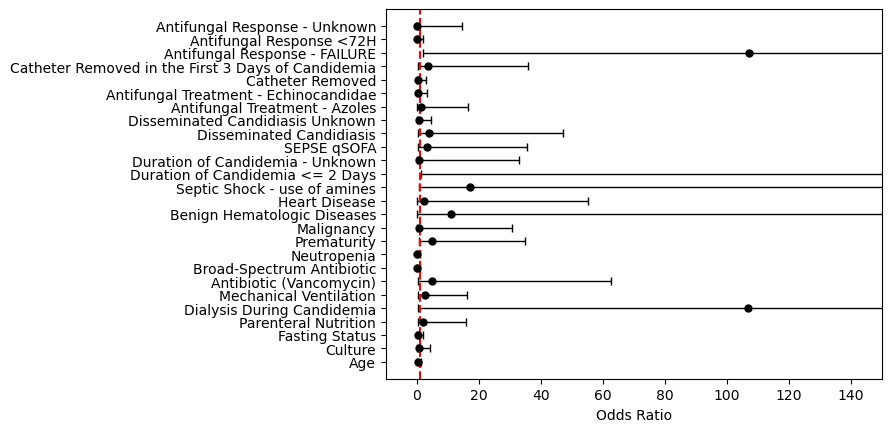

In [12]:
#Forest plot
#Get the odds ratio from all the variables
#Remove the value from const
odds= np.exp(model.params.drop('const'))


#CI
ci= np.exp(model.conf_int().loc[odds.index])

#CI
#ci=[]
#c_inter= np.exp(model.conf_int())
#for i in range(0, len(model.conf_int()[0][1:])):
#    ci.append([odds[i] - np.exp(model.conf_int()[0][i]), np.exp(model.conf_int()[1][i]) - odds[i]])
#Lower and upper CI
lower_ci = odds - ci[0]
upper_ci= ci[1] - odds

exerr = np.vstack([lower_ci, upper_ci])


#ci= np.vstack(ci)

#Index
#index_= model.conf_int().index.tolist()
#Remove the value from const
#del index_[0]

plt.errorbar(x= odds, y= odds.index, xerr=exerr,color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linestyle='--', color= 'red')
plt.xlabel('Odds Ratio')
plt.xlim(-10,150)
plt.savefig('FP_Relevant.jpg', bbox_inches='tight')
plt.show()

According with the plot, we can see that two of the relevant features (Duration of Candidemia <= 2 Days, and Antifungal Response - FAILURE) have a really wide confidence interval, beside that the odds ratio from Duration of Candidemia <= 2 Days is really big that is not even displayed on the forest plot. On the other hand, Neutropenia has a very small CI.

In [774]:
#Extracting relevant information

odds, coeff, pval, percent, indexes, ci=[],[],[],[],[],[]
for i,j in enumerate(model.pvalues):
    #Here we are selecting the outputs with a p-value smaller than 0.11
    if j <0.11:
        #Here we are adding one more condition, we are not only considering p-value we are also considering confidence interval(CI).
        #If the p-value is smaller that 0.11, then we check the CI, if the CI contains 0, we drop that covariate. On the other hand,
        #If the p-value is smaller than 0.11 and the CI does not contain zero, then that covariate is significant for the study.
        #What we are doing with this if is denying the CI that contains zero
        if not (model.conf_int()[0][i] < 0) & (model.conf_int()[1][i] > 0):
            #Get the parameters name
            indexes.append(model.params.index[i])
            
            #Odds ratio
            #print('Parameters:',model.params[i])
            odds.append(np.exp(model.params[i]))

            #Coefficient
            coeff.append(model.params[i])

            #P-values
            pval.append(round(model.pvalues[i],3))

            #CI
            ci.append(list(model.conf_int().values[i]))

#Percentage
for i in odds:
    if i < 1:
        percent.append(round((1-i)*100,3))
    else:
        percent.append(round((i-1)*100,3))

#ci= list(model.conf_int().drop('const').values)

#Create a table
table= pd.DataFrame({'Feature': indexes,'Coef': coeff, 'P-value': pval, 'Odds Ratio': odds, 'Percentage':percent, '[0.025      0.975]':ci}).set_index('Feature')
table

/var/folders/t4/0ysr6j1n08q2nnfdfqrmrj7h0000gn/T/ipykernel_1881/3906999378.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not (model.conf_int()[0][i] < 0) & (model.conf_int()[1][i] > 0):
/var/folders/t4/0ysr6j1n08q2nnfdfqrmrj7h0000gn/T/ipykernel_1881/3906999378.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  odds.append(np.exp(model.params[i]))
/var/folders/t4/0ysr6j1n08q2nnfdfqrmrj7h0000gn/T/ipykernel_1881/3906999378.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). 

,Coef,P-value,Odds Ratio,Percentage,[0.025 0.975]
Feature,,,,,
Neutropenia,-3.538074,0.047,0.029069,97.093,"[-7.031655872065853, -0.044491160020952325]"
Duration of Candidemia <= 2 Days,6.613501,0.041,745.087145,74408.714,"[0.28125017465166824, 12.945752193829161]"
Antifungal Response - FAILURE,4.675692,0.021,107.306773,10630.677,"[0.7032742726843315, 8.648109273169588]"


In [8]:
#Get the CIs droppint const
#list(model.conf_int().drop('const').values)
#Get CI from the first row
#model.conf_int().values[0]

# Interpretation of the outcomes

### Nutropenia

Neutropenia showed a statistically significant association with ICU admission, but in the opposite direction to what would be clinically expected. Patients with neutropenia had markedly lower odds of ICU admission (OR ≈ 0.03).</br>
However, this effect is likely distorted by sparse data and quasi-complete separation, since only a small number of neutropenic patients required ICU care. Therefore, the magnitude and direction of this association should be interpreted with caution, as it likely reflects data imbalance rather than a true protective effect of neutropenia.

#### Neutropenia × ICU crosstab

In [23]:
#Crosstab
neu_icu= pd.crosstab(data['Neutropenia'], data['ICU'])
neu_icu

ICU,0,1
Neutropenia,,
0,25,53
1,11,9


In [87]:
#ICU percentages

#Patients without neutropenia admitted to the ICU
no_neu=round((neu_icu.values[0][1])/(neu_icu.values[0][0]+neu_icu.values[0][1])*100,1)
#Patients with neutropenia admitted to ICU
neu=round((neu_icu.values[1][1])/(neu_icu.values[1][0]+neu_icu.values[1][1])*100,1)

print('Percentage of patients with Neutropenia admitted to ICU: %s%% \nPercentage of patients without Neutropenia admitted to ICU: %s%%' % (neu, no_neu))

Percentage of patients with Neutropenia admitted to ICU: 45.0% 
Percentage of patients without Neutropenia admitted to ICU: 67.9%


Patients with neutropenia were less likely to go to the ICU than patients with nuetropenia. This is surprising clinically, because neutropenia is typically a severity marker, but statistically the data shows:</br>
- More ICU admissions among non-neutropenic patients
- Fewer ICU admissions among neutropenic patients

In [100]:
#Unadjusted Odds Ratio
a = (neu_icu.values[0][0])*(neu_icu.values[1][1])
b = (neu_icu.values[0][1])*(neu_icu.values[1][0])

odds_r= round(a/b,3)
print('Unadjusted Odds Ratio: %s'%odds_r)

#Convert Odds ratio to lower odds
#If OR < 1:
lower_odds = round((1-odds_r)*100,1)
print('')
print('Neutropenic patients have approximately %s%% lower odds of ICU admission compared to non-neutropenic patients.'% lower_odds)

Unadjusted Odds Ratio: 0.386

Neutropenic patients have approximately 61.4% lower odds of ICU admission compared to non-neutropenic patients.


### Why is this happening?

- **Reason 1: Small sample size** </br>
Only 20 neutropenia patients, where only 9 were admitted to the ICU.
- **Confounding by disease severity**</br>
The other covariates are probably more common in ICU groups that is causing the model to “attribute” more severity to the other predictors, making neutropenia look even more protective.

In [170]:
#Just check variability on Neutropenia
events = data['ICU'].astype(bool)
print('Event: %s' % data.loc[events, 'Neutropenia'].var())
#Alternative for event: data.loc[data['ICU']==1,['Neutropenia']].var()
print('No Event: %s' % data.loc[~events, 'Neutropenia'].var())

Event: 0.1261237440507669
No Event: 0.21825396825396817


### Duration of Candidemia <= 2 Days

In accord with the outcomes, we can observer that *Duration of Candidemia <= 2 Days* has a statistical significant association with ICU, together with a positive coefficient, indicating that patients experienced candidemia for at most 2 days were more likely, or have much higher odds to be admitted to the ICU that patients that had experienced candidemia for a longer time. 

This outcome must be a sign of quasi-complete separation or small sample size. We can notice it in the huge odds ratio on the table, indicating that the predictor has a huge contrasts ICU and non-ICU patients, let's check it with a crosstab.

In [154]:
#Crosstab
less = pd.crosstab(data['Duration of Candidemia <= 2 Days'], data['ICU'])
less

ICU,0,1
Duration of Candidemia <= 2 Days,,
0,33,49
1,3,13


In [168]:
#Proportions
more_= round((less.values[0][1])/(less.values[0][1]+less.values[0][0])*100,1)
less_= round((less.values[1][1])/(less.values[1][1]+less.values[1][0])*100,1)

print('Percentage of patients that experienced candidemia less than 2 days admitted to ICU: %s%% \nPercentage of patients that experienced candidemia for more than 2 days and were admitted to ICU: %s%%' % (less_, more_))

Percentage of patients that experienced candidemia less than 2 days admitted to ICU: 81.2% 
Percentage of patients that experienced candidemia for more than 2 days and were admitted to ICU: 59.8%


The odds for *Duration of Candidemia <= 2 Days* is because the difference in odds is huge (81.2% vs 59.8%).</br>

Here, we are experiencing a **quasi-complete separation** issue, because the predictor (Duration of Candidemia <= 2 Days) almost perfectly predicts the outcome (ICU).</br>
The key problem is related with the sample size, according with the data:</br>
- Only 16 patients with Duration ≤ 2 days.
- Only 3 of them are non-ICU.
- 13 of them are ICU.

For logistic regression, this is *extremely small* and leads to **inflated coefficients**, like the one of 745.</br>
This **does not mean** the result is wrong — it means the variable strongly predicts ICU, but the sample is too small to estimate the effect stably.

In [178]:
#Check the values
data.loc[data['ICU']==0,['Duration of Candidemia <= 2 Days','ICU']]

,Duration of Candidemia <= 2 Days,ICU
1,0,0
3,0,0
5,1,0
7,0,0
9,0,0
10,0,0
13,0,0
21,0,0
22,0,0
23,0,0


Here, we can clearly perceive the **quasi-complete separation** issue, for the majority of patients that were not admitted in ICU there just a few patients that did experienced a candidemia for less than 3 days, in fact there are only three of them.

In [181]:
#Variability
events = data['ICU'].astype(bool)
print('Event: %s' % data.loc[events, 'Duration of Candidemia <= 2 Days'].var())
print('No Event: %s' % data.loc[~events, 'Duration of Candidemia <= 2 Days'].var())

Event: 0.16842940243257534
No Event: 0.07857142857142857


Checking the no event outcome, representing the people that experienced candidemia for more than 2 days, the variability is small close to zero.

### Antifungal Response - FAILURE

*Antifungal Response - FAILURE* shows the strongest statistical significance among the covariates, and here the direction of the coefficient actually makes clinical sense — severe infection not responding to antifungals likely pushes the patient to ICU. </br>

Coefficient is telling that patients with antifungal treatment failure have higher odds of ICU admission compared with those who responded to treatment. This is clinically consistent, because failure to respond increases disease severity, making ICU admission more likely. </br>

Unfortunately, we can see that the odds ratio, percentage and confidence intervalas are really big, this can be caused due to a small number of patients with failure in the antifungal treatment.

In [194]:
#Check crosstab
anti_fail= pd.crosstab(data['Antifungal Response - FAILURE'], data['ICU'])
anti_fail

ICU,0,1
Antifungal Response - FAILURE,,
0,35,44
1,1,18


In [202]:
#Percentage of Antifungal Response - FAILUR or not admitted to the ICU

failure=round((anti_fail.values[1][1])/(anti_fail.values[1][0] + anti_fail.values[1][1])*100,1)
#Alternative to select the values: pd.crosstab(data['Antifungal Response - FAILURE'], data['ICU']).values[0][0]
no_failure=round((anti_fail.values[0][1])/(anti_fail.values[0][0] + anti_fail.values[0][1])*100,1)

print('Percentage of patients with antifungal treatment failure who were admitted to the ICU: %s%%\nPercentage of patients without antifungal treatment failure who were admitted to the ICU: %s%%'%(failure, no_failure))

Percentage of patients with antifungal treatment failure who were admitted to the ICU: 94.7%
Percentage of patients without antifungal treatment failure who were admitted to the ICU: 55.7%


The 94.7% of patients addmited to the ICU due a failure of antifungal treatment clearly describe a quasi-complete separation issue, this phenomenom happens thanks to the small sample size of patients with antifungal failure, but here we can se that this **predictor actually describe the outcome**.</br>

From the 19 patients with antifungal failure **only one was not admitted to the ICU** and the rest indeed were admitted. Here, we can see the quasi-complete separation.

In [207]:
#Variability
events= data.ICU.astype(bool)
print('Event: %s' % data.loc[events, 'Antifungal Response - FAILURE'].var())
print('~Event: %s' % data.loc[~events, 'Antifungal Response - FAILURE'].var())

Event: 0.20941300898995271
~Event: 0.027777777777777735


# Conclusion

Taking into account the table with the relevant information gathered from the model, it's worthy to recognize that this model is not reliable. The inconsistency with the direction of the outcome of Neutropenia, the huge odds ratio from Duration of Candidemia <= 2 Days and Antifungal Response - FAILURE, and also wide confidence intervals confirm this statement. As an alternative, it's worthy to try add a penalizer or try with all the features instead with only the relevant ones.

# Adding a penalizer 

### Penalizer L1

In [14]:
#Fit a new logit
model_reg=sm.Logit(y,X)

In [16]:
#Add a penalizer
model_l1 = model_reg.fit_regularized(
        method='l1',      # l1 or l2 (elastic-net not yet implemented)
        alpha=0.1)        # overall penalty strength (larger ⇒ more shrinkage)
        #start_params=None,# optional starting values
        #maxiter=1000,
        #disp=False)

#Print the summary
print(model_l1.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3451476941912972
            Iterations: 184
            Function evaluations: 184
            Gradient evaluations: 184
                           Logit Regression Results                           
Dep. Variable:                    ICU   No. Observations:                   98
Model:                          Logit   Df Residuals:                       72
Method:                           MLE   Df Model:                           25
Date:                Wed, 10 Dec 2025   Pseudo R-squ.:                  0.5264
Time:                        15:23:21   Log-Likelihood:                -30.521
converged:                       True   LL-Null:                       -64.438
Covariance Type:            nonrobust   LLR p-value:                 8.028e-06
                                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

As we can see, adding a *L1* or *Lasso* penalizer does not fix the problem. As we can see in the table, almost all the features contain 0 on their confidence interval. The only feature not containing 0 is *Antifungal Response - FAILURE*, its CI actually got thicker and the covariate still having a statistical significant p-value.

In [22]:
#Extracting relevant information

odds, coeff, pval, percent, indexes, ci=[],[],[],[],[],[]
for i,j in enumerate(model_l1.pvalues):
    #Here we are selecting the outputs with a p-value smaller than 0.11
    if j <0.11:
        #Here we are adding one more condition, we are not only considering p-value we are also considering confidence interval(CI).
        #If the p-value is smaller that 0.11, then we check the CI, if the CI contains 0, we drop that covariate. On the other hand,
        #If the p-value is smaller than 0.11 and the CI does not contain zero, then that covariate is significant for the study.
        #What we are doing with this if is denying the CI that contains zero
        if not (model_l1.conf_int()[0][i] < 0) & (model_l1.conf_int()[1][i] > 0):
            #Get the parameters name
            indexes.append(model_l1.params.index[i])
            
            #Odds ratio
            #print('Parameters:',model.params[i])
            odds.append(np.exp(model_l1.params[i]))

            #Coefficient
            coeff.append(model_l1.params[i])

            #P-values
            pval.append(round(model_l1.pvalues[i],3))

            #CI
            ci.append(list(model_l1.conf_int().values[i]))

#Percentage
for i in odds:
    if i < 1:
        percent.append(round((1-i)*100,3))
    else:
        percent.append(round((i-1)*100,3))

#ci= list(model.conf_int().drop('const').values)

#Create a table
table= pd.DataFrame({'Feature': indexes,'Coef': coeff, 'P-value': pval, 'Odds Ratio': odds, 'Percentage':percent, '[0.025      0.975]':ci}).set_index('Feature')
table

/var/folders/t4/0ysr6j1n08q2nnfdfqrmrj7h0000gn/T/ipykernel_3842/3743482889.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not (model_l1.conf_int()[0][i] < 0) & (model_l1.conf_int()[1][i] > 0):
/var/folders/t4/0ysr6j1n08q2nnfdfqrmrj7h0000gn/T/ipykernel_3842/3743482889.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  odds.append(np.exp(model_l1.params[i]))
/var/folders/t4/0ysr6j1n08q2nnfdfqrmrj7h0000gn/T/ipykernel_3842/3743482889.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame be

,Coef,P-value,Odds Ratio,Percentage,[0.025 0.975]
Feature,,,,,
Antifungal Response - FAILURE,3.496162,0.033,32.988586,3198.859,"[0.2807928082626554, 6.7115304207028235]"


### Penalizer L2

In this section its gonna be applied a penalizer *L2* or *Ridge* to the relevant features. </br>

Unfortunately, the libary statsmodels does not support the L2 penalizer, to add it scikit learn library must be considered.

In [214]:
#Logistic regression with penalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#Drop const
X= X.drop(['const'], axis=1)

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

#Instantiate the model (using the default parameters)
logreg = LogisticRegression(penalty='l2',
                             #solver='lbfgs',   # works for L2
                             C=1.0,            # tune this: smaller ⇒ stronger penalty
                             fit_intercept=True,
                             max_iter=1000)

#logreg = make_pipeline(StandardScaler(), log_reg)
#logreg.fit(X, y)

#Fit the model with data
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Scikit learn does not provide a summry table, so in this case it's gonna be created from scratch.

In [217]:
#Summary table

# V = (X^T W X + αI)^{-1}  with W = diag(p(1-p))
from scipy.stats import norm
p = logreg.predict_proba(X)[:, 1]
W = np.diag(p * (1 - p))
X_design = np.column_stack([np.ones(X.shape[0]), X])   # add intercept
alpha = 1 / logreg.C                                   # sklearn uses C = 1/λ
penalty_matrix = np.diag([0] + [alpha] * X.shape[1])    # no penalty on intercept
cov_matrix = np.linalg.inv(X_design.T @ W @ X_design + penalty_matrix)

# --- standard errors, z, p, 95 % CI -----------------------------
coef_vec = np.concatenate([[logreg.intercept_[0]], logreg.coef_[0]])
se = np.sqrt(np.diag(cov_matrix))
z = coef_vec / se
p_values = 2 * norm.sf(np.abs(z))
ci_lower = coef_vec - norm.ppf(0.975) * se
ci_upper = coef_vec + norm.ppf(0.975) * se

# --- pretty table ----------------------------------------------
summary = pd.DataFrame({
        'coeff': coef_vec,
        'std err': se,
        'z': z,
        'P>|z|': p_values,
        '[0.025': ci_lower,
        '0.975]': ci_upper
    }, index=['const'] + X.columns.tolist())
print(summary.round(4))

                                                     coeff  std err       z  \
const                                               1.0602   1.3974  0.7587   
Age                                                -0.2795   0.2832 -0.9869   
Culture                                            -0.2674   0.5620 -0.4758   
Fasting Status                                     -0.5453   0.5514 -0.9888   
Parenteral Nutrition                                0.2822   0.5413  0.5214   
Dialysis During Candidemia                          0.2422   0.8220  0.2946   
Mechanical Ventilation                              0.6094   0.5623  1.0838   
Antibiotic (Vancomycin)                             0.3072   0.5520  0.5566   
Broad-Spectrum Antibiotic                          -0.7737   0.6247 -1.2384   
Neutropenia                                        -0.8049   0.6063 -1.3276   
Prematurity                                         0.4333   0.5933  0.7304   
Malignancy                                         -

As a conclusion from the table, L2 penalizer is not a good option. The reason is because all CIs have zero, making all features having no effect over ICU.

### Elastic Net Penalizer 

In [221]:
#Instantiate the model (using the default parameters)
logreg_elastic = LogisticRegression(penalty='elasticnet',
                             solver='saga',   # works for L2
                             l1_ratio=0.5,
                             C=1.0,            # tune this: smaller ⇒ stronger penalty
                             fit_intercept=True,
                             max_iter=1000)

#logreg = make_pipeline(StandardScaler(), log_reg)
#logreg.fit(X, y)

#Fit the model with data
logreg_elastic.fit(X_train, y_train)

LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                   solver='saga')

In [242]:
#Summary table

# V = (X^T W X + αI)^{-1}  with W = diag(p(1-p))
p = logreg_elastic.predict_proba(X)[:, 1]
W = np.diag(p * (1 - p))
X_design = np.column_stack([np.ones(X.shape[0]), X])   # add intercept
alpha = 1 / logreg_elastic.C                                   # sklearn uses C = 1/λ
penalty_matrix = np.diag([0] + [alpha] * X.shape[1])    # no penalty on intercept
cov_matrix = np.linalg.inv(X_design.T @ W @ X_design + penalty_matrix)

# --- standard errors, z, p, 95 % CI -----------------------------
coef_vec = np.concatenate([[logreg_elastic.intercept_[0]], logreg_elastic.coef_[0]])
se = np.sqrt(np.diag(cov_matrix))
z = coef_vec / se
p_values = 2 * norm.sf(np.abs(z))
ci_lower = coef_vec - norm.ppf(0.975) * se
ci_upper = coef_vec + norm.ppf(0.975) * se

# --- pretty table ----------------------------------------------
summary = pd.DataFrame({
        'coeff': coef_vec,
        'std err': se,
        'z': z,
        'P>|z|': p_values,
        '[0.025': ci_lower,
        '0.975]': ci_upper
    }, index=['const'] + X.columns.tolist())
print(summary.round(4))

                                                     coeff  std err       z  \
const                                               0.9669   1.3740  0.7037   
Age                                                -0.3061   0.2787 -1.0980   
Culture                                            -0.1531   0.5511 -0.2779   
Fasting Status                                     -0.3979   0.5455 -0.7294   
Parenteral Nutrition                                0.1985   0.5328  0.3725   
Dialysis During Candidemia                          0.0000   0.8051  0.0000   
Mechanical Ventilation                              0.5891   0.5563  1.0589   
Antibiotic (Vancomycin)                             0.2193   0.5441  0.4031   
Broad-Spectrum Antibiotic                          -0.6171   0.6126 -1.0074   
Neutropenia                                        -0.6956   0.6038 -1.1521   
Prematurity                                         0.2916   0.5834  0.4999   
Malignancy                                         -

As we can notice, after applying *Elastic Net Penalizer* non of the features have an effect over the outcome variable becaues all the CIs contain zero.

# Logistic Regression with all features

In this section its goona be applied a Logistic Regression together with all the features from the dataset. To do so, it is importan to mention that a penalizer must be used due to a problem of singular matrix as we can se below.</br>

All three penalizers are gonna be applied to see the effect of all three of them, *L1* or *Lasso*, *L2* or *Ridge*, and *Net Elastic*.

### Penalizer L1

In [176]:
#Define explanatory variables
X=data.drop(['Catheter Removed in the First 3 Days of Candidemia - Unknown','Duration of Candidemia <= 2 Days','No SEPSE qSOFA','Catheter Removal Unknown',
             'ICU','Duration of Candidemia - Unknown','SEPSE qSOFA Unknown','Antifungal Treatment - Combination', 'Disseminated Candidiasis Unknown',
             'No Antifungal Treatment','Antifungal Response - Unknown','No Disseminated Candidiasis','Catheter Not Removed','Catheter Not Removed in the First 3 Days of Candidemia',
             'Duration of Candidemia 3-7 Days', 'Time in ICU'],axis=1)

#Define the dependent variable
y=data['ICU']

#Z-standarization of continous features
#The only continous columns are: Age and Complete Antifungal Treatment in days
for i in ['Age', 'Complete Antifungal Treatment in days']:
    X[i]=(X[i]- X[i].mean())/X[i].std()
    
#Add a constant
X=sm.add_constant(X)

#Fit the model
model=sm.Logit(y,X)
model_fit= model.fit_regularized(
#    method='l1',
#    alpha=0.1,
#    maxiter=500
)

#Print summary
print(model_fit.summary())

/Users/diegovonborries/anaconda3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.19422399502925e-11
            Iterations: 163
            Function evaluations: 164
            Gradient evaluations: 163


LinAlgError: Singular matrix

In [5]:
#Define explanatory variables
X=data.drop(['Catheter Removed in the First 3 Days of Candidemia - Unknown','Duration of Candidemia <= 2 Days','No SEPSE qSOFA','Catheter Removal Unknown',
             'ICU','Duration of Candidemia - Unknown','SEPSE qSOFA Unknown','Antifungal Treatment - Combination', 'Disseminated Candidiasis Unknown',
             'No Antifungal Treatment','Antifungal Response - Unknown','No Disseminated Candidiasis','Catheter Not Removed','Catheter Not Removed in the First 3 Days of Candidemia',
             'Duration of Candidemia 3-7 Days', 'Time in ICU'],axis=1)

#Define the dependent variable
y=data['ICU']

#Z-standarization of continous features
#The only continous columns are: Age and Complete Antifungal Treatment in days
for i in ['Age', 'Complete Antifungal Treatment in days']:
    X[i]=(X[i]- X[i].mean())/X[i].std()
    
#Add a constant
X=sm.add_constant(X)

#Fit the model
model=sm.Logit(y,X)
model_fit= model.fit_regularized(
    method='l1',
    alpha=0.1,
    maxiter=500
)

#Print summary
print(model_fit.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.25328873747112046
            Iterations: 300
            Function evaluations: 300
            Gradient evaluations: 300
                           Logit Regression Results                           
Dep. Variable:                    ICU   No. Observations:                   98
Model:                          Logit   Df Residuals:                       68
Method:                           MLE   Df Model:                           29
Date:                Tue, 09 Dec 2025   Pseudo R-squ.:                  0.7167
Time:                        08:24:16   Log-Likelihood:                -18.253
converged:                       True   LL-Null:                       -64.438
Covariance Type:            nonrobust   LLR p-value:                 1.565e-08
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------

To apply a logistic regression to most of the features, a penalizer was required due to the large number of predictors relative to the sample size. Having a small sample with many covariates increases the risk of overfitting and quasi-complete separation, making the standard maximum likelihood estimation unstable.</br>

The features used as reference were: 

- No SEPSE qSOFA
- SEPSE qSOFA Unknown
- Catheter Not Removed
- Catheter Removal Unknown
- No Antifungal Treatment
- Antifungal Treatment - Combination
- Duration of Candidemia 3-7 Days
- Duration of Candidemia <= 2 Days
- Duration of Candidemia - Unknown
- Disseminated Candidiasis Unknown
- Antifungal Response - Unknown
- No Disseminated Candidiasis
- Catheter Not Removed in the First 3 Days of Candidemia
- Catheter Removed in the First 3 Days of Candidemia - Unknown

In [174]:
#Extracting relevant information

odds, coeff, pval, percent, indexes, ci=[],[],[],[],[],[]
for i,j in enumerate(model_fit.pvalues):
    #Here we are selecting the outputs with a p-value smaller than 0.11
    if j <0.11:
        #Here we are adding one more condition, we are not only considering p-value we are also considering confidence interval(CI).
        #If the p-value is smaller that 0.11, then we check the CI, if the CI contains 0, we drop that covariate. On the other hand,
        #If the p-value is smaller than 0.11 and the CI does not contain zero, then that covariate is significant for the study.
        #What we are doing with this if is denying the CI that contains zero
        if not (model_fit.conf_int()[0][i] < 0) & (model_fit.conf_int()[1][i] > 0):
            #Get the parameters name
            indexes.append(model_fit.params.index[i])
            
            #Odds ratio
            #print('Parameters:',model.params[i])
            odds.append(np.exp(model_fit.params[i]))

            #Coefficient
            coeff.append(model_fit.params[i])

            #P-values
            pval.append(round(model_fit.pvalues[i],3))

            #CI
            ci.append(list(model_fit.conf_int().values[i]))

#Percentage
for i in odds:
    if i < 1:
        percent.append(round((1-i)*100,3))
    else:
        percent.append(round((i-1)*100,3))

#ci= list(model.conf_int().drop('const').values)

#Create a table
table= pd.DataFrame({'Feature': indexes,'Coef': coeff, 'P-value': pval, 'Odds Ratio': odds, 'Percentage':percent, '[0.025      0.975]':ci}).set_index('Feature')
table

/var/folders/t4/0ysr6j1n08q2nnfdfqrmrj7h0000gn/T/ipykernel_1655/1907158546.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not (model_fit.conf_int()[0][i] < 0) & (model_fit.conf_int()[1][i] > 0):
/var/folders/t4/0ysr6j1n08q2nnfdfqrmrj7h0000gn/T/ipykernel_1655/1907158546.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  odds.append(np.exp(model_fit.params[i]))
/var/folders/t4/0ysr6j1n08q2nnfdfqrmrj7h0000gn/T/ipykernel_1655/1907158546.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame

,Coef,P-value,Odds Ratio,Percentage,[0.025 0.975]
Feature,,,,,
"Central Venous Device (CVC, PICC, Hickman, Broviac, Semi-Implantable)",-7.885760,0.002,0.000376,99.962,"[-12.87033090797906, -2.901190031289901]"
Fasting Status,-4.002129,0.032,0.018277,98.172,"[-7.655571843768848, -0.34868536763392033]"
Parenteral Nutrition,5.000632,0.006,148.506927,14750.693,"[1.459757530799993, 8.54150567896934]"
Septic Shock - use of amines,5.356103,0.026,211.897510,21089.751,"[0.6256721501778637, 10.086533277303253]"
SEPSE qSOFA,3.377201,0.028,29.288663,2828.866,"[0.36078610480289175, 6.393614932949591]"
Antifungal Response - FAILURE,7.835561,0.003,2528.952663,252795.266,"[2.691818218061462, 12.979302839883703]"


The table shows the most relevant outcomes after applying a logistic regression with a *Lasso* or *L1* penalizer.</br>

- **Central Venous Device (CVC, PICC, Hickman, Broviac, Semi-Implantable)** According with the model, this feature shows a negative coefficient indicating that patients having a central venous device have lower odds to be admitted to ICU than patients that do not have the device. Specifically, patients who have a central venous device have almost 100% odds of avoiding ICU. We can notice a strong statistical pvalue.</br>
- **Fasting Status** Presents a similar effect over ICU, has a negative coefficient indicating that fasting patients have lower odds to need intensive care than non-fasting patients. The percentage is also almost 100%, and also shows a relevant pvalue.</br>
- The rest of the features shows the same problem as we saw earlier, eventhough they show statistical significance their Odds are way to big as well as their CIs. This can be caused due to small simple size effects and possible quasi-complete separation issues.

### Forest Plot

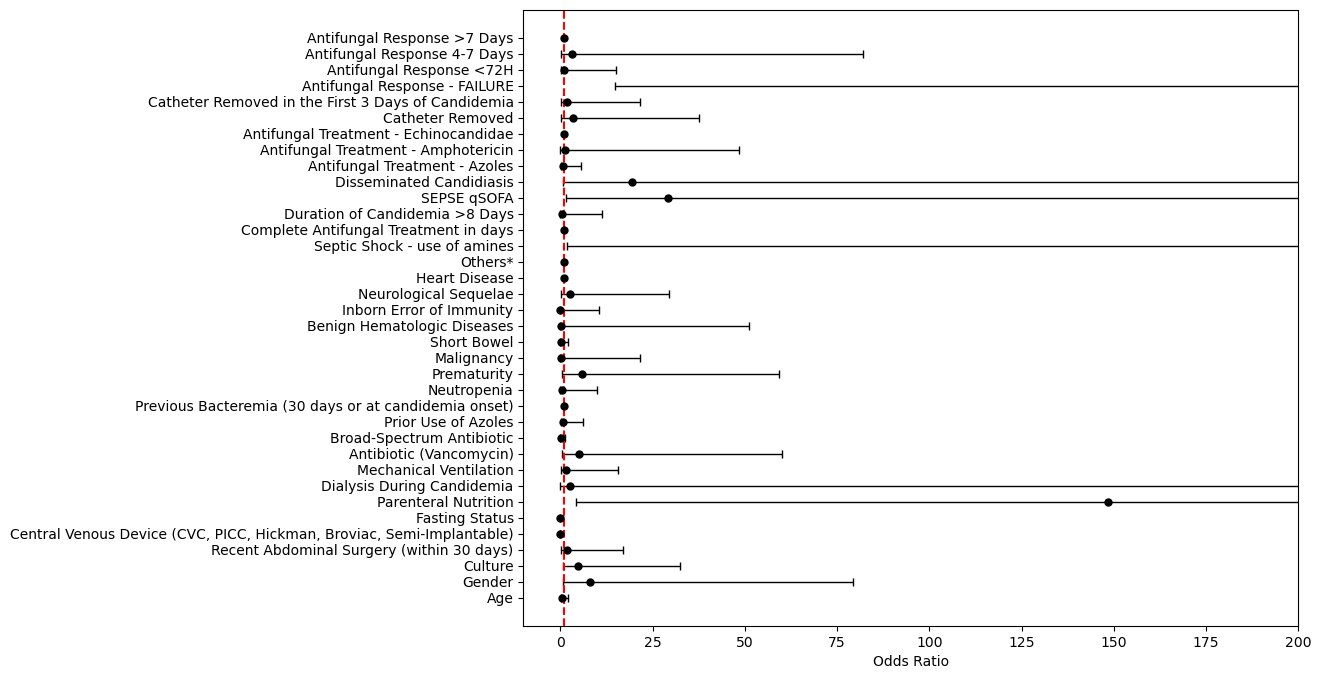

In [30]:
#Forest plot
#Get the odds ratio from all the variables
#Remove the value from const
odds= np.exp(model_fit.params.drop('const'))


#CI
ci= np.exp(model_fit.conf_int().loc[odds.index])

#CI
#ci=[]
#c_inter= np.exp(model.conf_int())
#for i in range(0, len(model.conf_int()[0][1:])):
#    ci.append([odds[i] - np.exp(model.conf_int()[0][i]), np.exp(model.conf_int()[1][i]) - odds[i]])
#Lower and upper CI
lower_ci = odds - ci[0]
upper_ci= ci[1] - odds

exerr = np.vstack([lower_ci, upper_ci])


#ci= np.vstack(ci)

#Index
#index_= model.conf_int().index.tolist()
#Remove the value from const
#del index_[0]
figure= plt.figure(figsize=(10,8))
plt.errorbar(x= odds, y= odds.index, xerr=exerr,color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linestyle='--', color= 'red')
plt.xlabel('Odds Ratio')
plt.xlim(-10,200)
plt.savefig('ForestPlotFullModel.jpg',bbox_inches = 'tight')
plt.show()

### Penalizer L2

In [183]:
#Logistic regression with penalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#Drop const
X= X.drop(['const'], axis=1)

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

#Instantiate the model (using the default parameters)
logreg = LogisticRegression(penalty='l2',
                             #solver='lbfgs',   # works for L2
                             C=1.0,            # tune this: smaller ⇒ stronger penalty
                             fit_intercept=True,
                             max_iter=1000)

#logreg = make_pipeline(StandardScaler(), log_reg)
#logreg.fit(X, y)

#Fit the model with data
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [185]:
#Summary table

# V = (X^T W X + αI)^{-1}  with W = diag(p(1-p))
from scipy.stats import norm
p = logreg.predict_proba(X)[:, 1]
W = np.diag(p * (1 - p))
X_design = np.column_stack([np.ones(X.shape[0]), X])   # add intercept
alpha = 1 / logreg.C                                   # sklearn uses C = 1/λ
penalty_matrix = np.diag([0] + [alpha] * X.shape[1])    # no penalty on intercept
cov_matrix = np.linalg.inv(X_design.T @ W @ X_design + penalty_matrix)

# --- standard errors, z, p, 95 % CI -----------------------------
coef_vec = np.concatenate([[logreg.intercept_[0]], logreg.coef_[0]])
se = np.sqrt(np.diag(cov_matrix))
z = coef_vec / se
p_values = 2 * norm.sf(np.abs(z))
ci_lower = coef_vec - norm.ppf(0.975) * se
ci_upper = coef_vec + norm.ppf(0.975) * se

# --- pretty table ----------------------------------------------
summary = pd.DataFrame({
        'coeff': coef_vec,
        'std err': se,
        'z': z,
        'P>|z|': p_values,
        '[0.025': ci_lower,
        '0.975]': ci_upper
    }, index=['const'] + X.columns.tolist())
print(summary.round(4))

                                                     coeff  std err       z  \
const                                               1.1583   1.4987  0.7729   
Age                                                -0.4482   0.3196 -1.4026   
Gender                                              0.5001   0.5139  0.9732   
Culture                                            -0.2394   0.5761 -0.4157   
Recent Abdominal Surgery (within 30 days)           0.1022   0.6177  0.1655   
Central Venous Device (CVC, PICC, Hickman, Brov... -0.7719   0.7650 -1.0089   
Fasting Status                                     -0.6080   0.5752 -1.0571   
Parenteral Nutrition                                0.7322   0.5877  1.2457   
Dialysis During Candidemia                          0.1531   0.8432  0.1816   
Mechanical Ventilation                              0.6476   0.5870  1.1031   
Antibiotic (Vancomycin)                             0.5018   0.5805  0.8643   
Broad-Spectrum Antibiotic                          -

According with the outcom table, the only singnificant feature is *Antifungal Response - FAILURE* having a statistical significant pvalue and considerable thick confindence interval. The rest of the features didn't even get a pvalue closer to 0.1.

### Elastic Net Penalizer

In [238]:
#Instantiate the model (using the default parameters)
logreg_elastic_all = LogisticRegression(penalty='elasticnet',
                             solver='saga',   # works for L2
                             l1_ratio=0.5,
                             C=1.0,            # tune this: smaller ⇒ stronger penalty
                             fit_intercept=True,
                             max_iter=1000)

#logreg = make_pipeline(StandardScaler(), log_reg)
#logreg.fit(X, y)

#Fit the model with data
logreg_elastic_all.fit(X_train, y_train)

LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                   solver='saga')

In [240]:
#Summary table

# V = (X^T W X + αI)^{-1}  with W = diag(p(1-p))
p = logreg_elastic_all.predict_proba(X)[:, 1]
W = np.diag(p * (1 - p))
X_design = np.column_stack([np.ones(X.shape[0]), X])   # add intercept
alpha = 1 / logreg_elastic_all.C                                   # sklearn uses C = 1/λ
penalty_matrix = np.diag([0] + [alpha] * X.shape[1])    # no penalty on intercept
cov_matrix = np.linalg.inv(X_design.T @ W @ X_design + penalty_matrix)

# --- standard errors, z, p, 95 % CI -----------------------------
coef_vec = np.concatenate([[logreg_elastic_all.intercept_[0]], logreg_elastic_all.coef_[0]])
se = np.sqrt(np.diag(cov_matrix))
z = coef_vec / se
p_values = 2 * norm.sf(np.abs(z))
ci_lower = coef_vec - norm.ppf(0.975) * se
ci_upper = coef_vec + norm.ppf(0.975) * se

# --- pretty table ----------------------------------------------
summary = pd.DataFrame({
        'coeff': coef_vec,
        'std err': se,
        'z': z,
        'P>|z|': p_values,
        '[0.025': ci_lower,
        '0.975]': ci_upper
    }, index=['const'] + X.columns.tolist())
print(summary.round(4))

                                                     coeff  std err       z  \
const                                               0.9657   1.3740  0.7029   
Age                                                -0.3061   0.2787 -1.0980   
Culture                                            -0.1527   0.5511 -0.2771   
Fasting Status                                     -0.3979   0.5455 -0.7294   
Parenteral Nutrition                                0.1986   0.5328  0.3728   
Dialysis During Candidemia                          0.0000   0.8051  0.0000   
Mechanical Ventilation                              0.5890   0.5563  1.0589   
Antibiotic (Vancomycin)                             0.2194   0.5441  0.4032   
Broad-Spectrum Antibiotic                          -0.6169   0.6126 -1.0071   
Neutropenia                                        -0.6956   0.6038 -1.1520   
Prematurity                                         0.2917   0.5834  0.4999   
Malignancy                                         -

After applying *Elastic Net* penalizer we had the same effect as with penalizer *L2*, the only relevant feature is *Antifungal Response - FAILURE*. The rest do not even have a pvalue closer to 0.1 and contains zero within their CIs.

# Conclusion

After analyzing each of the outcomes from the differents models applied in this notebook, we can claim that most of the models have inconsistencies on the outcomes caused most of the time due to the small sample size from the dataset, we have seen the same issue of *quasi-complete separation* repeated frequently with most of the features. As a good alternative, a **Bayesian Logistic Regression** should be considered, this technique can handle the small sample size problem that affected most of this analysis.